In [1]:
from __future__ import division
import imageio
import numpy as np
import scipy as sp
import scipy.fftpack as ft
import PIL
import cv2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


(32, 32, 8, 8, 3)
(256, 256, 3)


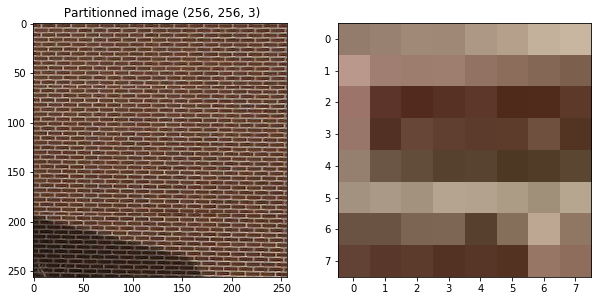

In [10]:
import imageio as imio
image = imio.imread('Moire.jpg')
n = 120
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
cropped_rgb = image[n:n+256,n:n + 256]
plt.title(" Image " + str(np.shape(cropped_rgb)))

plt.imshow(cropped_rgb)
# Step 1 : divide in 8x8 matrixes
divided = np.array((cropped_rgb.shape[0] // 8) * [(cropped_rgb.shape[1] // 8) * [np.zeros((8, 8, 3))]])
print(divided.shape)
print(cropped_rgb.shape)

for i in range(cropped_rgb.shape[0]):
    for j in range(cropped_rgb.shape[1]):
        divided[i//8][j//8][i % 8][j % 8] = cropped_rgb[i][j]
        # Step 2 : Normalize : cropped[i][j] - 128
        #print(i//8, j//8, i % 8, j % 8)

plt.title(" Partitionned image " + str(np.shape(cropped_rgb)))
plt.subplot(1,2,2)
plt.imshow(divided[7][1].astype('uint8'))

(32, 32, 8, 8, 3)
(256, 256, 3)


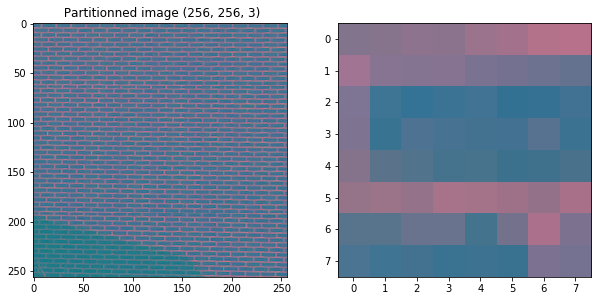

In [11]:
from PIL import Image
img = Image.open('Moire.jpg')
img_yuv = img.convert('YCbCr')

image = asarray(img_yuv)
n = 120
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
cropped_yuv = image[n:n+256,n:n + 256]
plt.title(" Image " + str(np.shape(cropped_yuv)))

plt.imshow(cropped_yuv)
# Step 1 : divide in 8x8 matrixes
divided = np.array((cropped_yuv.shape[0] // 8) * [(cropped_yuv.shape[1] // 8) * [np.zeros((8, 8, 3))]])
print(divided.shape)
print(cropped_yuv.shape)

for i in range(cropped_yuv.shape[0]):
    for j in range(cropped_yuv.shape[1]):
        divided[i//8][j//8][i % 8][j % 8] = cropped_yuv[i][j]
        # Step 2 : Normalize : cropped[i][j] - 128
        #print(i//8, j//8, i % 8, j % 8)

plt.title(" Partitionned image " + str(np.shape(cropped_yuv)))
plt.subplot(1,2,2)
plt.imshow(divided[7][1].astype('uint8'))

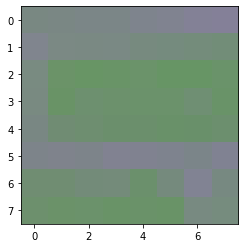

In [63]:
# Step 3 : Convert to YUV
def RGBtoYUV(px):
    # SO version
    R = px[0]
    G = px[1]
    B = px[2]
    Y =  0.257 * R + 0.504 * G + 0.098 * B +  16
    U = -0.148 * R - 0.291 * G + 0.439 * B + 128
    V =  0.439 * R - 0.368 * G - 0.071 * B + 128
    
    return [Y, U, V]

def YUVtoRGB(px):
    # SO version
    Y = px[0] - 16;
    U = px[1] - 128;
    V = px[2] - 128;
    R = 1.164 * Y             + 1.596 * V;
    G = 1.164 * Y - 0.392 * U - 0.813 * V;
    B = 1.164 * Y + 2.017 * U;
    
    return [R, G, B]

def matRGBtoYUV(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = RGBtoYUV(mat[i][j])
            
def matYUVtoRGB(mat):
    for i in range(8):
        for j in range(8):
            mat[i][j] = YUVtoRGB(mat[i][j])

for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matRGBtoYUV(divided[i][j])
        
for i in range(divided.shape[0]):
    for j in range(divided.shape[1]):
        matYUVtoRGB(divided[i][j])
        
plt.imshow(divided[7][1].astype('uint8'))

In [4]:
# Step 2 : subsampling the image
def subsampling(x, d):
    p = 2
    if d == 0:
        y = x[::p, :]
    elif d == 1:
        y = x[:, ::p]
    return y

# Below is a circular convolution implemented. 
def cconv(x, h, d):
    if d == 1:
        return np.transpose(cconv(np.transpose(x), h, 0))
    y = np.zeros(x.shape)
    p = len(h)
    pc = int(round( float((p - 1) / 2 )))
    for i in range(0, p):
        y = y + h[i] * np.roll(x, pc-i, axis=0)
    return y

h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h) ## make sure the filter has norm 1.
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))
print("low-pass filter associated with the scaling function",h)
print("high-pass filter associated with the wavelet function",g)

low-pass filter associated with the scaling function [ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
high-pass filter associated with the wavelet function [ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


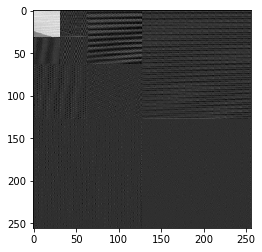

In [5]:
#Step 3 : Wavelet transform
def coarse(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by h along the dimension d.
    return subsampling(cconv(image, h, d), d) #filtre passe bas sur l'image

def fine(image,d):
    # d is the dimension along which the operation is performed.
    # the formula to be implemented is the convolution of x by g along the dimension d.
    return subsampling(cconv(image, g, d), d) #filtre passe haut sur l'image

def W_0(image,wavelet_coeff=None):
    # start with the first dimension index 0 to get coarse and fine description along this axis
    
    # process again the previous results to get coarse and fine description along the axis of index 1.
    # you thus should have 4 sub-images of the same size which is the initial image size divided by 4 (divide columns and rows by 2).
    
    # concatenate your results in an array called results
    c = coarse(image, 0)
    f = fine(image, 0)
    
    cc = coarse(c, 1)
    cf = coarse(f, 1)
    fc = fine(c, 1)
    ff = fine(f, 1)
    
    res1 = concatenate([cc, fc], axis = 0)
    res2 = concatenate([cf, ff], axis = 0)
    return concatenate([res1, res2], axis = 1)
    

def WaveletTransform(image,iterations =1):
    ## iterate the 1step wavelet transform implemented above.
    if iterations == 0 :
        return image
    
    half = shape(image)[0] // 2
    
    w0 = W_0(image)
    LL = w0[:half, :half]
    LH = w0[:half, half:]
    HL = w0[half:, :half]
    HH = w0[half:, half:]
    
    LL = WaveletTransform(LL, iterations - 1)
    
    res1 = np.concatenate([LL, HL], axis = 0)
    res2 = np.concatenate([LH, HH], axis = 0)
    return np.concatenate([res1, res2], axis = 1)

it = 3
Wt = WaveletTransform(cropped, it)
plt.imshow(Wt)

array([[0.52209199, 0.40136836, 0.35776104, ..., 0.6131034 , 0.63857684,
        0.61689573],
       [0.74193598, 0.73280477, 0.6984321 , ..., 0.60578149, 0.65521163,
        0.66683866],
       [0.72365018, 0.7206619 , 0.73769185, ..., 0.15568429, 0.12920063,
        0.21905998],
       ...,
       [0.5659243 , 0.53261084, 0.40852078, ..., 0.5114291 , 0.51269843,
        0.61393044],
       [0.49815806, 0.51229738, 0.5050336 , ..., 0.45333077, 0.47672539,
        0.51978092],
       [0.51641615, 0.50383699, 0.5050125 , ..., 0.42099716, 0.62293715,
        0.75649876]])

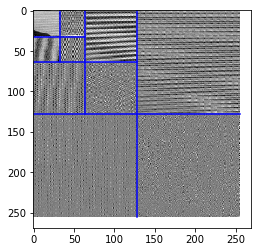

In [6]:
def rescale(f,a=0,b=1):
    ## function that rescale f between a and b.
    rang = f.max() - f.min()
    g = (f - f.min()).copy()
    if rang > 0:
        g = g / rang
    return a + g*(b-a)

def rescaleWav(A):
    ## function dedicated to a proper rescale of wavelet representation (particular case of the previous one).
    sup = abs(A).max()
    B = A.copy()
    if sup > 0:
        B = .5 + .5 * A / sup
    return B
    
def PlotWavelet(wavelet, iterations=1):
    ## Plot the wavelet representation, need to specify the number of iterations (or scales at which the FWT is computed).
    n = wavelet.shape[1]
    Jmax = int(np.log2(n)) - 1
    Jmin = Jmax - iterations + 1
    
    U = wavelet.copy()
    for j in np.arange(Jmax, Jmin - 1, -1):
        U[:2 ** j:,    2 ** j:2 **
            (j + 1):] = rescaleWav(U[:2 ** j:, 2 ** j:2 ** (j + 1):])
        U[2 ** j:2 ** (j + 1):, :2 **
          j:] = rescaleWav(U[2 ** j:2 ** (j + 1):, :2 ** j:])
        U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):] = (
            rescaleWav(U[2 ** j:2 ** (j + 1):, 2 ** j:2 ** (j + 1):]))
    # coarse scale
    U[:2 ** j:, :2 ** j:] = rescale(U[:2 ** j:, :2 ** j:])
    # plot underlying image
    plt.imshow(U)
    # display crosses
    for j in np.arange(Jmax, Jmin - 1, -1):
        plt.plot([0, 2 ** (j + 1)], [2 ** j, 2 ** j], 'b')
        plt.plot([2 ** j, 2 ** j], [0, 2 ** (j + 1)], 'b')
    return U

PlotWavelet(Wt, it)

## Links
### Jpeg 2000
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG2000.htm
- https://www2.ulb.ac.be/cours/acohen/travaux_2006_infodoc/CompressionNumerique/TypeDonneesImageJPEG.htm#Le_JPEG

### RGB to YUV
- https://stackoverflow.com/questions/17892346/how-to-convert-rgb-yuv-rgb-both-ways
- https://fr.wikipedia.org/wiki/YUV